# Simple audio recognition: Recognizing keywords

This tutorial will show you how to build a basic speech recognition network that recognizes ten different words. It's important to know that real speech and audio recognition systems are much more complex, but like MNIST for images, it should give you a basic understanding of the techniques involved. Once you've completed this tutorial, you'll have a model that tries to classify a one second audio clip as "down", "go", "left", "no", "right", "stop", "up" and "yes".

## Setup

Import necessary modules and dependencies.

In [ ]:
import os
import pathlib
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

You'll write a script to download a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license.

You'll be using a portion of the dataset to save time with data loading. Extract the `mini_speech_commands.zip` and load it in using the `tf.data` API.

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

Check basic statistics about the dataset.

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'left' 'stop' 'up' 'yes' 'no' 'go' 'down']


Extract the audio files into a list and shuffle it.

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/5c8af87a_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Reading audio files and their labels

The label for each WAV file is its parent directory.

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [ ]:

# A WAV file contains time series data with a set number of samples per second. 
# Each sample represents the amplitude of the audio signal at that specific time. 
# In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz.

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  # Read the wave encoded audio file from the file as a binary file
  audio_binary = tf.io.read_file(file_path)
  #tf.audio.decode_wav will normalize the 16-bit binary sample values to the range [-1.0, 1.0] float32.
  audio, sample_rate = tf.audio.decode_wav(contents=audio_binary,desired_channels=-1,desired_samples=-1)
  #since the second dimension is useless due to float values, remove it.
  waveform = tf.squeeze(audio,axis=-1)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
#slice the tensor across its first dimension
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

[16000]
[16000]
[16000]
[16000]
[16000]
[16000]
[14861]
[16000]
[16000]


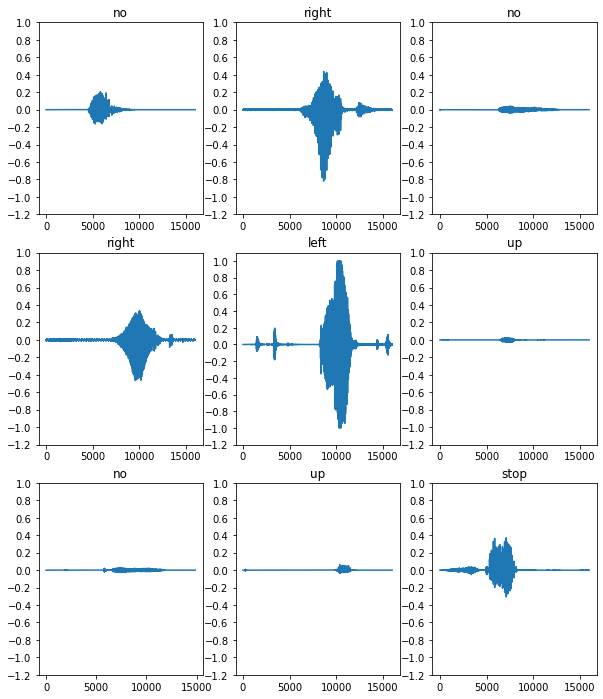

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  #In order to plot; need to convert the tensor to a numpy array
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
  print(tf.shape(audio).numpy())

plt.show()

## Spectrogram

Most important section. Convert the audio to an image for feature extraction.

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [ ]:
def rem_zeros(x):
  if x > 0.0:
    return x 
  else:
    return 1.0E-14


def get_spectrogram(waveform):
  # Padding with zeros for files with less than 16000 samples
  padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, padding], 0)

  #!!!!!!!!!! Most important step !!!!!!!!!!
  spectrogram = tf.signal.stft(
      signals=equal_length, frame_length=255, frame_step=128,fft_length = 256,window_fn=tf.signal.hann_window,pad_end=True)
      
  spectrogram = tf.cast(tf.abs(spectrogram),dtype=tf.float32)

  #This is to ensure that the spectrograms absolute value does not have zero values since log is taken later
  ori_shape = spectrogram.get_shape()
  print("original shape",ori_shape)
  reshaped_spec = tf.reshape(tf.cast(spectrogram,dtype=tf.float32),shape=(16125,1))
  #reshaped_spec = np.array(reshaped_spec)
  reshaped_spec = tf.map_fn(rem_zeros,reshaped_spec)
  spectrogram = tf.reshape(tf.cast(reshaped_spec, dtype=tf.float32),shape=ori_shape)
  later_shape = spectrogram.get_shape()
  print("later shape",later_shape)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

original shape (125, 129)
later shape (125, 129)
Label: no
Waveform shape: (16000,)
Spectrogram shape: (125, 129)
Audio playback


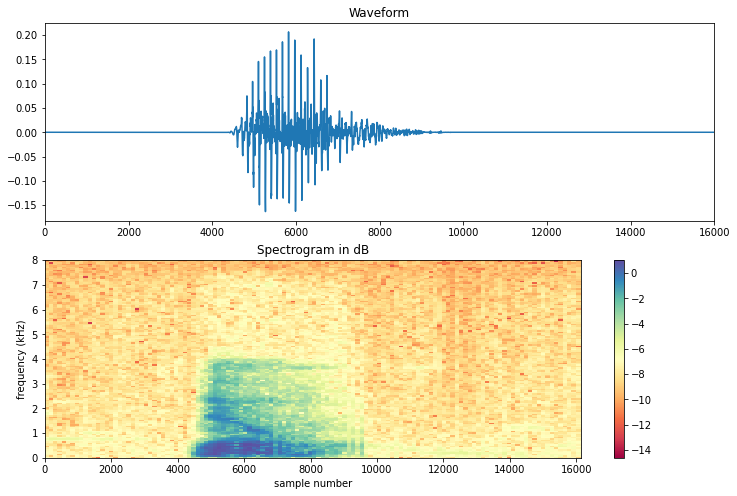

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  #log_spec_dB = np.array([10.0*x for x in log_spec])
  #lenght of frequency axis
  height = log_spec.shape[0]
  #lenght of small time
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  sampling_rate = 16.0
  fft_points = 256.0
  factor = sampling_rate/fft_points
  #Convert fft samples into real frequency using sampling rate and fft values. Then get the log2 to get what humans perceive.
  #Y = np.array([math.log2(x*factor) if x!=0 else 0 for x in Y ])
  Y = np.array([x*factor for x in Y ])
  ## This is another important function in plotting the spectrogram.
  cmap1 = plt.get_cmap('Spectral')
  spec = ax.pcolormesh(X, Y, log_spec,cmap=cmap1,vmax=log_spec.max(),vmin=log_spec.min())
  return spec


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
spec = plot_spectrogram(spectrogram.numpy(), axes[1])
cmap1 = plt.get_cmap('Spectral')
fig.colorbar(spec,cmap=cmap1)
axes[1].set_title('Spectrogram in dB')
axes[1].set_yscale("linear")
#axes[1].set_ylim(ymax=20)
#axes[1].set_ylabel('logarithmic frequency')
axes[1].set_ylabel('frequency (kHz)')
axes[1].set_xlabel('sample number')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  #spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

original shape (None, 129)


OperatorNotAllowedInGraphError: ignored

Examine the spectrogram "images" for different samples of the dataset.

(129, 125)
(129, 125)
(129, 125)
(129, 125)
(129, 125)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


(129, 125)
(129, 125)
(129, 125)
(129, 125)


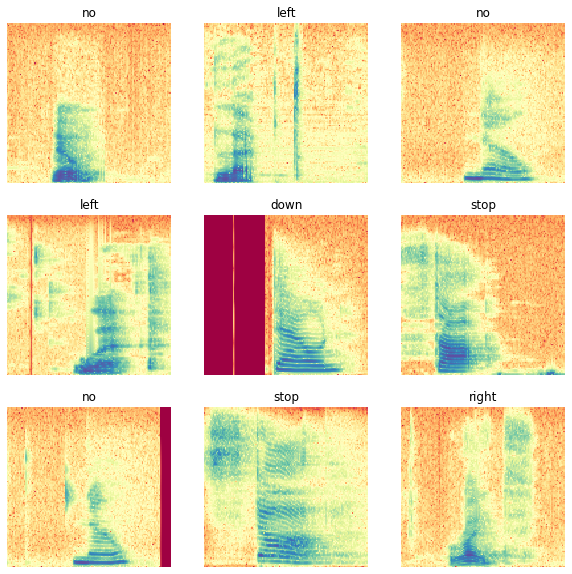

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

NameError: ignored

Batch the training and validation sets for model training.

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 47s 182ms/step - loss: 1.7214 - accuracy: 0.3742 - val_loss: 1.2436 - val_accuracy: 0.5975
Epoch 2/10
100/100 [==============================] - 1s 13ms/step - loss: 1.1621 - accuracy: 0.5927 - val_loss: 0.8828 - val_accuracy: 0.7088
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.8999 - accuracy: 0.6809 - val_loss: 0.7295 - val_accuracy: 0.7400
Epoch 4/10
100/100 [==============================] - 1s 11ms/step - loss: 0.7585 - accuracy: 0.7311 - val_loss: 0.6421 - val_accuracy: 0.7738
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 0.6496 - accuracy: 0.7669 - val_loss: 0.5885 - val_accuracy: 0.7875
Epoch 6/10
100/100 [==============================] - 1s 12ms/step - loss: 0.5760 - accuracy: 0.7992 - val_loss: 0.5784 - val_accuracy: 0.7962
Epoch 7/10
100/100 [==============================] - 1s 12ms/step - loss: 0.4940 - accuracy: 0.8231 - val_loss: 0.5176 - val_accuracy: 0.80

Let's check the training and validation loss curves to see how your model has improved during training.

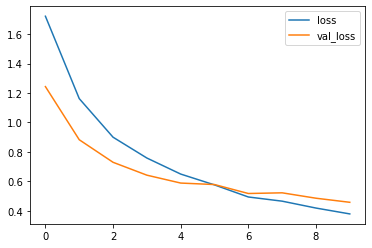

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 82%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

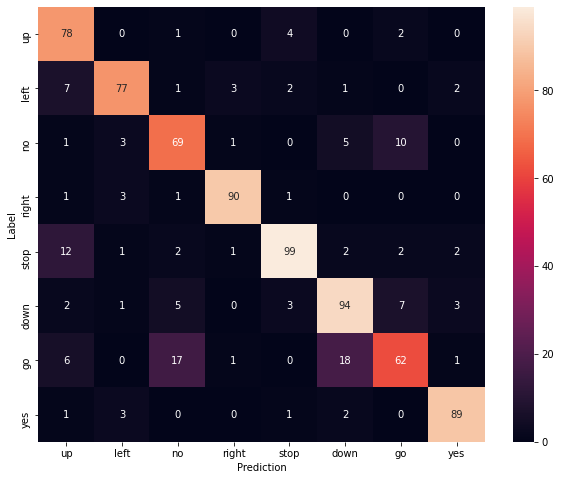

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

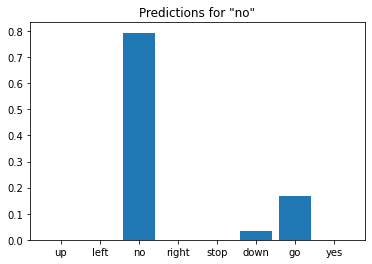

In [ ]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

You can see that your model very clearly recognized the audio command as "no."

## Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
